# Autoencoder for getting vector embeddings

**Advisor:** Marcos M. Raimundo <br>
**Co-Advisor:** Thalita Veronese <br>
**Student:** João Victor P. B. Avanzini

## Imports

In [7]:
import tensorflow as tf
import os

import neurokit2 as nk


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input, Conv1DTranspose, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Conv1DTranspose, Reshape
from tensorflow.keras.optimizers import Adam

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2



2023-12-09 20:44:09.252072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-09 20:44:09.252653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


## 140 Subjects of single ECG autoencoder

In [2]:
subjects = pd.read_csv('../data/merged_ecg_data.csv')
subjects = subjects[:42000000]

In [3]:
subjects.shape

(42000000, 1)

In [4]:
subjects_reshaped = subjects.values.reshape((1400, 30000, 1))
subjects_reshaped.shape

(1400, 30000, 1)

## 30 Subjects ECG autoencoder

In [5]:
encoder = tf.keras.models.Sequential([
    Conv1D(64, 1400, activation='relu', padding='same', input_shape=(30000, 1)),
    Dense(32, activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 1400, activation='relu', padding='same'),
    Dense(16, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(8)
    
], name='encoder')

2023-12-09 20:42:14.677254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-09 20:42:14.677456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


In [6]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30000, 64)         89664     
                                                                 
 dense (Dense)               (None, 30000, 32)         2080      
                                                                 
 max_pooling1d (MaxPooling1  (None, 15000, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15000, 32)         1433632   
                                                                 
 dense_1 (Dense)             (None, 15000, 16)         528       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7500, 16)          0         
 g1D)                                                      

In [7]:
decoder = tf.keras.models.Sequential([
    Reshape((8, 1)),
    Conv1DTranspose(8, 29993, activation='relu', input_shape=(8, 1)),
    Dense(16, activation='relu'),
    Conv1DTranspose(16, 1400, activation='relu', padding='same'),
    Dense(32, activation='relu'),
    Conv1DTranspose(32, 1400, activation='relu', padding='same'),
    Dense(64, activation='relu'),
    Conv1DTranspose(1, 1400, activation='relu', padding='same'),
], name='decoder')

In [8]:
#decoder.summary()

In [9]:
autoencoder = Sequential([encoder, decoder])
autoencoder.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 8)                 2485912   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d (Conv1D)            (None, 30000, 64)         89664    |
|                                                               |
| dense (Dense)              (None, 30000, 32)         2080     |
|                                                               |
| max_pooling1d (MaxPooling  (None, 15000, 32)         0        |
| 1D)                                                           |
|                                                               |
| conv1d_1 (Conv1D)          (None, 15000, 32)         1433632  |
|                                                               |
| dense_1 (Dense)            (None, 15000, 16)         528      |
|                                                       

In [9]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-12-09 20:44:46.212770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-09 20:44:46.213150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


In [11]:
with strategy.scope():
    encoder = tf.keras.models.Sequential([
        Conv1D(64, 1300, activation='relu', padding='same', input_shape=(30000, 1)),
        Dense(32, activation='relu'),
        MaxPooling1D(),
        Conv1D(32, 1300, activation='relu', padding='same'),
        Dense(16, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(8)
    ], name='encoder')

    decoder = tf.keras.models.Sequential([
        Reshape((8, 1)),
        Conv1DTranspose(8, 29993, activation='relu', input_shape=(8, 1)),
        Dense(16, activation='relu'),
        Conv1DTranspose(16, 1300, activation='relu', padding='same'),
        Dense(32, activation='relu'),
        Conv1DTranspose(32, 1300, activation='relu', padding='same'),
        Dense(64, activation='relu'),
        Conv1DTranspose(1, 1300, activation='relu', padding='same'),
    ], name='decoder')

    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(optimizer="adam", loss="mse")

In [ ]:
history = autoencoder.fit(subjects_reshaped, subjects_reshaped, batch_size=128, epochs=100, verbose=1)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 24 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 24 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-12-09 20:45:26.928623: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-09 20:45:26.975297: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-09 20:56:04.567267: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe060896290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-09 20:56:04.567297: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-09 20:56:04.567303: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-09 20:56:04.576990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702155364.698429     899 device_compiler.h:186] Compiled clust

11/11 [==============================] - ETA: 0s - loss: 0.1196 INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
11/11 [==============================] - 1447s 80s/step - loss: 0.1196
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 2/100
 4/11 [=========>....................] - ETA: 2:39 - loss: 0.1052

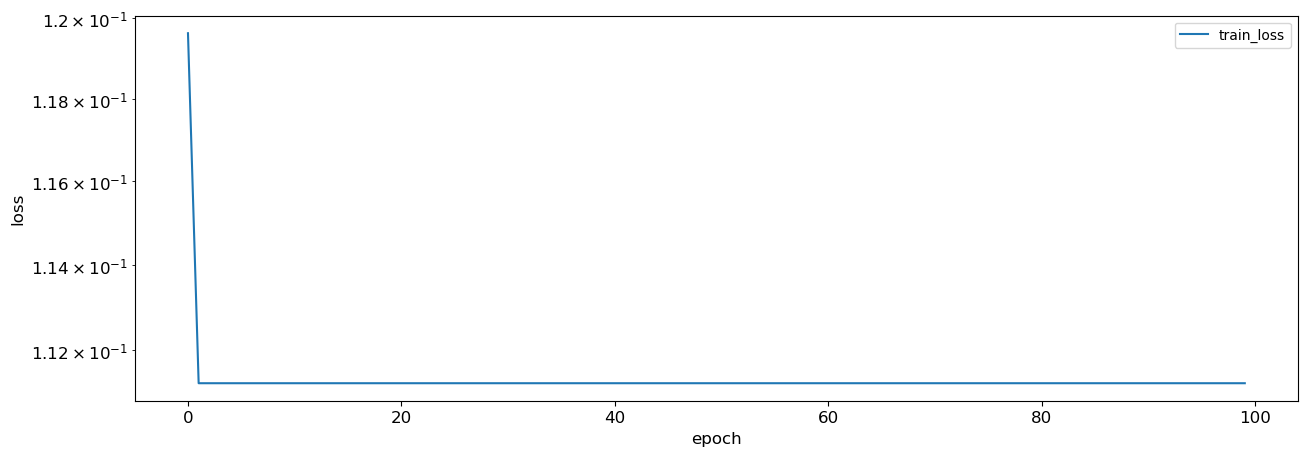

In [47]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

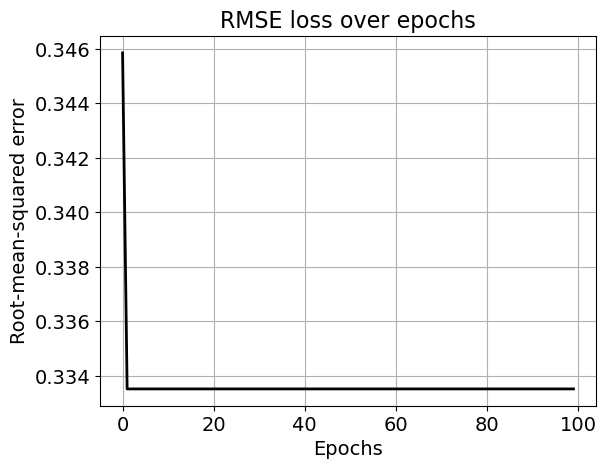

In [17]:
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE', c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [18]:
print("Epoch\tRMSE")
for epoch, rmse in enumerate(np.sqrt(history.history['loss'])):
    print(f"{epoch}\t{rmse}")

Epoch	RMSE
0	0.3458486670901732
1	0.33352408563923036
2	0.33352408563923036
3	0.33352408563923036
4	0.33352408563923036
5	0.33352407446975113
6	0.33352408563923036
7	0.33352408563923036
8	0.33352408563923036
9	0.33352408563923036
10	0.33352408563923036
11	0.33352408563923036
12	0.33352407446975113
13	0.33352405213079145
14	0.33352407446975113
15	0.33352408563923036
16	0.33352407446975113
17	0.33352407446975113
18	0.33352408563923036
19	0.33352407446975113
20	0.33352407446975113
21	0.33352408563923036
22	0.33352405213079145
23	0.33352407446975113
24	0.33352408563923036
25	0.33352408563923036
26	0.33352408563923036
27	0.33352408563923036
28	0.33352408563923036
29	0.33352408563923036
30	0.33352408563923036
31	0.33352408563923036
32	0.33352407446975113
33	0.33352405213079145
34	0.33352408563923036
35	0.33352408563923036
36	0.33352408563923036
37	0.33352408563923036
38	0.33352407446975113
39	0.33352408563923036
40	0.33352408563923036
41	0.33352407446975113
42	0.33352408563923036
43	0.333524

In [36]:
file_path = f'inference_merged_ecg_data.csv'
subject_data = pd.read_csv(file_path)
subject_data.shape

(9000000, 1)

In [46]:
autoencoder.save('140_subjects_model.h5')

## Inference process

In [37]:
def process_subject(ax, subject_number):
    file_path = f'inference_merged_ecg_data.csv'
    
    subject_data = pd.read_csv(file_path)
    
    subject_data = subject_data[:9000000]
    
    subject_data = subject_data.values.reshape((300, 30000, 1))
    
    encoder_embeddings = encoder.predict(subject_data)
    
    ax.plot(encoder_embeddings)
    ax.set_title(f'Subject {subject_number}')
    
    return encoder_embeddings.flatten()

10/10 [==============================] - 3s 318ms/step


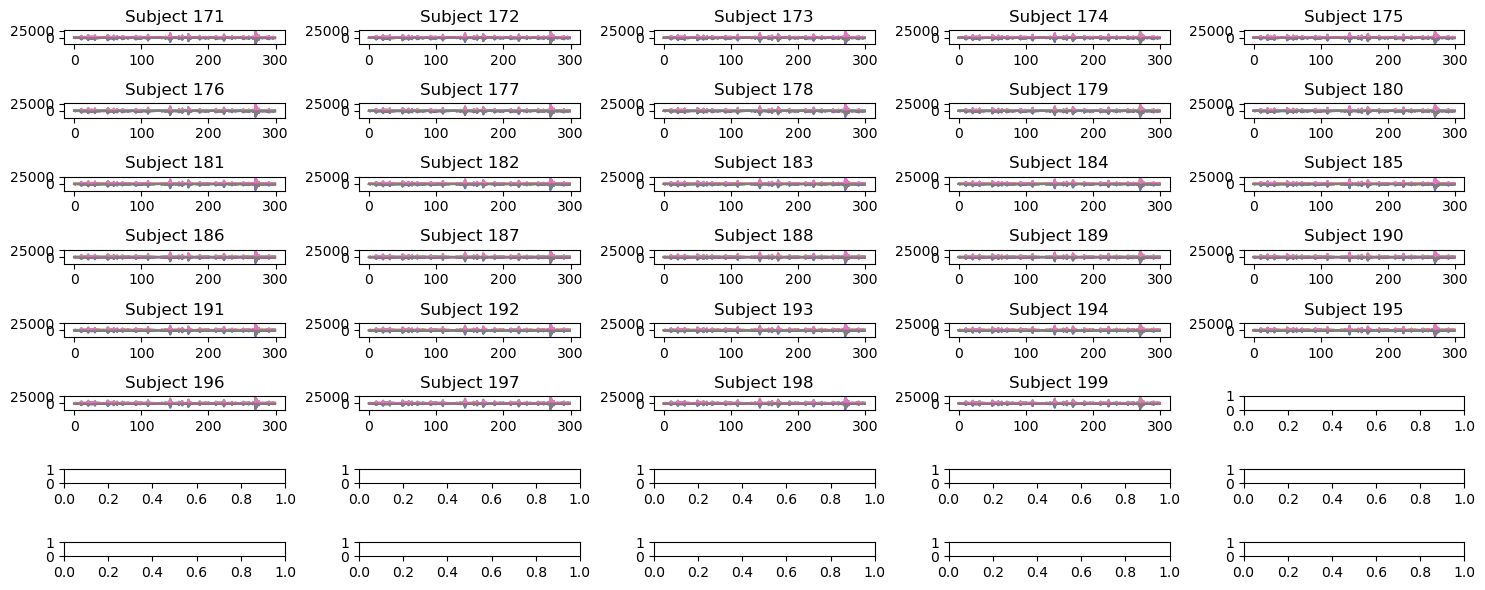

In [41]:
fig, axes = plt.subplots(8, 5, figsize=(15, 6))

embeddings_list = []
for ax, subject_number in zip(axes.flatten(), range(171, 200)):
    embeddings = process_subject(ax, subject_number)
    embeddings_list.append(embeddings)

plt.tight_layout()
plt.show()

In [42]:
embeddings_df = pd.DataFrame(embeddings_list)
embeddings_df.to_csv('encoder_inference_v2_embeddings.csv', index=False)

In [45]:
embeddings_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,-285.268494,279.059906,270.361267,-190.947220,-267.491547,-191.677124,313.947083,-225.645126,-1029.572388,1016.261597,...,1835.875,-1280.949219,-1632.585571,1586.890381,1517.014282,-1028.010864,-1517.264526,-1066.828491,1797.768188,-1257.407471
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,-285.268463,279.059875,270.361267,-190.947205,-267.491516,-191.677109,313.947083,-225.645142,-1029.572388,1016.261536,...,1835.875,-1280.949219,-1632.585449,1586.890259,1517.013916,-1028.010742,-1517.264404,-1066.828613,1797.767822,-1257.407471
25%,-285.268463,279.059875,270.361267,-190.947205,-267.491516,-191.677109,313.947083,-225.645142,-1029.572388,1016.261536,...,1835.875,-1280.949219,-1632.585449,1586.890259,1517.013916,-1028.010742,-1517.264404,-1066.828613,1797.767822,-1257.407471
50%,-285.268463,279.059875,270.361267,-190.947205,-267.491516,-191.677109,313.947083,-225.645142,-1029.572388,1016.261536,...,1835.875,-1280.949219,-1632.585449,1586.890259,1517.013916,-1028.010742,-1517.264404,-1066.828613,1797.767822,-1257.407471
75%,-285.268463,279.059875,270.361267,-190.947205,-267.491516,-191.677109,313.947083,-225.645142,-1029.572388,1016.261536,...,1835.875,-1280.949219,-1632.585449,1586.890259,1517.013916,-1028.010742,-1517.264404,-1066.828613,1797.767822,-1257.407471
max,-285.268463,279.059875,270.361267,-190.947205,-267.491516,-191.677109,313.947083,-225.645142,-1029.572388,1016.261536,...,1835.875,-1280.949219,-1632.585449,1586.890259,1517.013916,-1028.010742,-1517.264404,-1066.828613,1797.767822,-1257.407471
